In [1]:
import warnings
warnings.simplefilter("ignore")
import os
import sys
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import time
import logging
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftfreq, fftshift, fftn
import matplotlib.pyplot as plt
from pylab import *

from utils import NeuralNet, create_ds, poisson

In [2]:
class MultistageNeuralNetwork:
    """
    MultistageNeuralNetwork is a multi-stage model used for predicting
    high-dimensional function outputs through regression. This class encapsulates
    the functionality for constructing, training, and predicting using a sequence
    of neural networks, where each stage of the network can focus on different
    aspects of the data.

    Attributes:
        dim (int): Dimensionality of the input data.
        N (int): Number of points per dimension in the dataset.
        stages (list): List of neural networks, one for each stage.
        layers (list): Architecture of the neural network (input layer, hidden layers, output layer).
        lt (list): Minimum values for each dimension in the input data.
        ut (list): Maximum values for each dimension in the input data.
    """

    def __init__(self, x_train, num_hidden_layers, num_hidden_nodes):
        """
        Initialize the MultistageNeuralNetwork instance.

        Args:
            x_train (tf.Tensor): Input training data.
            num_stages (int): Number of stages in the multi-stage neural network.
            num_hidden_layers (int): Number of hidden layers in each stage.
            num_hidden_nodes (int): Number of nodes in each hidden layer.
        """
        self.dim = x_train.shape[-1]                                 # Number of dimensions in the input data.
        self.N = int(round(x_train.shape[0] ** (1 / self.dim)))      # Number of points per dimension.
        # self.stages = [None] * num_stages                            # List to store each stage's neural network.
        self.stages = []
        self.layers = [self.dim] + ([num_hidden_nodes] * num_hidden_layers) + [1]  # Neural network architecture.
        self.lt = [tf.math.reduce_min(x_train[:, i]) for i in range(x_train.shape[-1])]  # Min values for each dimension.
        self.ut = [tf.math.reduce_max(x_train[:, i]) for i in range(x_train.shape[-1])]  # Max values for each dimension.

    def train(self, x_train, y_train, stage, kappa, iters):
        """
        Train a specific stage of the neural network.

        Args:
            x_train (tf.Tensor): Input training data.
            y_train (tf.Tensor): Corresponding labels for training.
            stage (int): The stage index to train.
            kappa (float): Scaling factor for activation.
            iters (list): Number of iterations for [Adam optimizer, L-BFGS optimizer].
        """
        act = 0 if stage == 0 else 1  # Use different activation for first stage.
        lt = [tf.cast(tf.math.reduce_min(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]
        ut = [tf.cast(tf.math.reduce_max(x_train[:, i]).numpy(), dtype=tf.float64) for i in range(x_train.shape[-1])]

        self.stages.append(NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act))
        # self.stages[stage] = NeuralNet(x_train, y_train, self.layers, kappa=kappa, lt=lt, ut=ut, acts=act)
        self.stages[stage].train(iters[0], 1)  # Train using Adam optimizer.
        self.stages[stage].train(iters[1], 2)  # Train using L-BFGS optimizer.

    @staticmethod
    def fftn_(x_train, residue):
        """
        Perform a Fast Fourier Transform (FFT) to analyze the frequency domain of the residue.

        Args:
            x_train (tf.Tensor): Input training data.
            residue (tf.Tensor): Residual errors between predictions and true values.

        Returns:
            float: Adjusted scaling factor (kappa) based on the dominant frequency.
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy()

        GG = g.reshape([N_train] * dim)  # Reshape residue into a grid.
        G = fftn(GG)                    # Perform FFT.
        G_shifted = fftshift(G)         # Shift zero-frequency component to the center.

        N = len(G)
        total_time_range = 2  # Time range from -1 to 1.
        sample_rate = N / total_time_range  # Sampling rate.

        half_N = N // 2
        T = 1.0 / sample_rate
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]  # Extract positive frequencies.

        freqs = [fftshift(fftfreq(GG.shape[i], d=T)) for i in range(len(GG.shape))]
        freq_pos = [freqs[i][half_N:] for i in range(len(freqs))]

        magnitude_spectrum = np.abs(G_pos)
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(len(freq_pos))]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)  # Normalize magnitude.

        dominant_freq = max(dominant_freqs)
        # print(f"Sample rate = {sample_rate} Hz, Dominant Frequency = {dominant_freq} Hz, Magnitude = {magnitude}")

        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        # print(f"New Kappa: {kappa_f}")
        return kappa_f, dominant_freq
    
    def sfftn(x_train, residue, sparsity_threshold=0.01, k=None):
        """
        Perform a Sparse Fast Fourier Transform (SFFT) to analyze the frequency domain of the residue,
        optimized for high-dimensional data. Assumes data is already on a complete grid.

        Args:
            x_train (tf.Tensor): Input training data with coordinates.
            residue (tf.Tensor): Residual errors between predictions and true values.
            sparsity_threshold (float): Threshold below which frequency components are set to zero (relative to max).
            max_frequencies (int, optional): Maximum number of frequency components to keep. If None, use threshold only.

        Returns:
            tuple: (kappa_f, dominant_freq, sparse_spectrum)
                - kappa_f: Adjusted scaling factor based on the dominant frequency
                - dominant_freq: The dominant frequency identified
                - sparse_spectrum: Sparse representation of the frequency spectrum
        """
        dim = x_train.shape[-1]
        N_train = int(round(x_train.shape[0] ** (1 / dim)))
        g = residue.numpy().flatten()
        
        grid = g.reshape([N_train] * dim)

        # For very high dimensions, we may need to use a smaller grid
        downsample_factor = 1
        if dim > 4:
            downsample_factor = max(1, N_train // 16)

        slices = tuple(slice(None, None, downsample_factor) for _ in range(dim))
        GG = grid[slices]
        G = fftn(GG)
        G_shifted = fftshift(G)
        
        N = GG.shape[0]
        total_time_range = 2  # Time range from -1 to 1
        sample_rate = N / total_time_range
        half_N = N // 2
        T = 1.0 / sample_rate
        
        idxs = tuple(slice(half_N, N, 1) for _ in range(dim))
        G_pos = G_shifted[idxs]
        
        freqs = [fftshift(fftfreq(N, d=T)) for _ in range(dim)]
        freq_pos = [freqs[i][half_N:] for i in range(dim)]

        magnitude_spectrum = np.abs(G_pos)
        max_magnitude = np.max(magnitude_spectrum)

        if sparsity_threshold > 0:
            mask = magnitude_spectrum > (sparsity_threshold * max_magnitude)
            if k is not None and np.sum(mask) > k:
                flat_idx = np.argsort(magnitude_spectrum.flatten())[::-1][:k]
                new_mask = np.zeros_like(magnitude_spectrum, dtype=bool).flatten()
                new_mask[flat_idx] = True
                mask = new_mask.reshape(magnitude_spectrum.shape)
        else:
            mask = np.ones_like(magnitude_spectrum, dtype=bool)
        
        sparse_magnitude = np.zeros_like(magnitude_spectrum)
        sparse_magnitude[mask] = magnitude_spectrum[mask]
        
        max_idx = np.unravel_index(np.argmax(magnitude_spectrum), magnitude_spectrum.shape)
        dominant_freqs = [freq_pos[i][max_idx[i]] for i in range(dim)]
        magnitude = magnitude_spectrum[max_idx] / (N ** dim)
        
        dominant_freq = max(dominant_freqs)
        kappa_f = 2 * np.pi * dominant_freq if dominant_freq > 0 else 2 * np.pi * 0.01
        
        if dim <= 2:
            sparse_spectrum = sparse_magnitude
        else:
            sparse_idx = np.where(mask)
            values = magnitude_spectrum[sparse_idx]
            sparse_spectrum = (sparse_idx, values, magnitude_spectrum.shape)
        
        return kappa_f, dominant_freq, sparse_spectrum

    def find_zeros(residue):
        sign_residue = np.sign(residue)
        num_zeros = 0
        for axis in range(residue.ndim):
            shifted_signs = np.roll(sign_residue, shift=-1, axis=axis)
            mask = (sign_residue[:-1] * shifted_signs[:-1]) < 0
            num_zeros += np.count_nonzero(mask)
        kappa = 3 * num_zeros
        return kappa

In [9]:
dim = 1
L = 2.04
num_stages = 4
num_hidden_layers = 3
num_hidden_nodes = 20
precision = 1e-8
points_per_dim = 20

N_train = points_per_dim ** dim
x_train = create_ds(dim, -L/2, L/2, N_train)
y_train = tf.reshape(poisson(x_train), [len(x_train), 1])
training_iters = list([(3000, 6000)] + [(5000, 8000*i) for i in range(2, 15)])[:num_stages]

print(x_train.shape, y_train.shape)

(20, 1) (20, 1)


In [4]:
# STAGE 1
MSNN_SFFT = MultistageNeuralNetwork(x_train, num_hidden_layers, num_hidden_nodes)
# MSNN_FFT = MultistageNeuralNetwork(x_train, num_hidden_layers, num_hidden_nodes)
kappa = 1
print(f"TRAINING STAGE {1}: Data size: {x_train.shape}")
MSNN_SFFT.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])
curr_residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(1)])
mean_residue = tf.reduce_mean(tf.abs(curr_residue_sfft))
print(f"Completed training stage 1, loss={MSNN_SFFT.stages[-1].loss[-1]}, residue={mean_residue}")

# MSNN_FFT.train(x_train, y_train, stage=0, kappa=1, iters=training_iters[0])
# curr_residue_fft = y_train - tf.add_n([MSNN_FFT.stages[j].predict(x_train) for j in range(1)])
# mean_residue = tf.reduce_mean(tf.abs(curr_residue_fft))
# print(f"Completed training stage 1, loss={MSNN_FFT.stages[-1].loss[-1]}, residue={mean_residue}")

TRAINING STAGE 1: Data size: (5000, 1)


LBFGS Optimization:  50%|████▉     | 2999/6000 [00:42<00:40, 74.41iter/s]


Mode: LBFGSIter: 3000, loss: 2.1586e-08


LBFGS Optimization:  90%|████████▉ | 5389/6000 [01:15<00:08, 71.15iter/s]

Completed training stage 1, loss=9.187131682900217e-09, residue=8.504314912407021e-05


In [5]:
def test_sfftn():
    # Generating synthetic data for testing
    dim = 5  # High-dimensional test case
    N_train = 16  # Choosing a grid size that works with subsampling
    x_train = tf.convert_to_tensor(np.random.rand(N_train**dim, dim), dtype=tf.float64)
    residue = tf.convert_to_tensor(np.random.randn(N_train**dim), dtype=tf.float64)

    # Call the modified sfftn function
    try:
        kappa_s, dominant_freqs, sparse_spectrum = MultistageNeuralNetwork.sfftn(x_train, residue)
        kappa_f, dominant_freq = MultistageNeuralNetwork.fftn_(x_train, residue)
        print(f"kappa_s: {kappa_s}, s_dom: {dominant_freqs}")
        print(f"kappa_f: {kappa_f},  f_dom: {dominant_freq}")

        if isinstance(sparse_spectrum, tuple):
            sparse_idx, values, shape = sparse_spectrum
            print(f"Sparse Spectrum Indices (sample): {sparse_idx[:10]}")
            print(f"Sparse Spectrum Values (sample): {values[:10]}")
            print(f"Original Spectrum Shape: {shape}")
        else:
            print(f"Sparse Spectrum: {sparse_spectrum[:10]}")

        # Additional checks
        assert kappa_f > 0, "kappa_f should be positive."
        assert dominant_freq >= 0, "Dominant frequency should be non-negative."
        assert isinstance(sparse_spectrum, (tuple, np.ndarray)), "Sparse spectrum format is incorrect."

        print("All checks passed.")
    except Exception as e:
        print(f"Error during testing: {e}")

test_sfftn()

kappa_s: 18.84955592153876, s_dom: 3.0
kappa_f: 18.84955592153876,  f_dom: 3.0
Sparse Spectrum Indices (sample): (array([0, 0, 0, ..., 7, 7, 7]), array([0, 0, 0, ..., 7, 7, 7]), array([0, 0, 0, ..., 7, 7, 7]), array([0, 0, 0, ..., 7, 7, 7]), array([0, 1, 2, ..., 5, 6, 7]))
Sparse Spectrum Values (sample): [ 960.10244587  370.31774601 1074.8031383   247.94068826  466.69622013
  654.50130036  883.04549284 1079.67897144  761.98172164  753.08114388]
Original Spectrum Shape: (8, 8, 8, 8, 8)
All checks passed.


In [5]:
i = 1
while i < num_stages:
    # kappa_f, _ = MultistageNeuralNetwork.fftn_(x_train, curr_residue_fft)
    kappa_s, _, _ = MultistageNeuralNetwork.sfftn(x_train, curr_residue_sfft)
    print(f"TRAINING STAGE {i + 1}")

    curr_residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(i)])
    MSNN_SFFT.train(x_train, curr_residue_sfft, stage=i, kappa=kappa_s, iters=training_iters[i])
    print(f"Completed training stage {i + 1} SFFT, loss={MSNN_SFFT.stages[-1].loss[-1]}")

    # curr_residue_fft = y_train - tf.add_n([MSNN_FFT.stages[j].predict(x_train) for j in range(i)])
    # MSNN_FFT.train(x_train, curr_residue_fft, stage=i, kappa=kappa_f, iters=training_iters[i])
    # print(f"Completed training stage {i + 1} FFT, loss={MSNN_FFT.stages[-1].loss[-1]}")
    i += 1

if i >= num_stages:
        print(f"Reached maximum stages, loss={MSNN_SFFT.stages[-1].loss[-1]}, residue={mean_residue}")
else:
    print(f"Exited training unexpectedly, previous loss={MSNN_SFFT.stages[-2].loss[-1]}, previous residue={mean_residue}")

TRAINING STAGE 2


LBFGS Optimization:  19%|█▊        | 2994/16000 [00:39<02:47, 77.79iter/s]


Mode: LBFGSIter: 3000, loss: 9.0277e-14


LBFGS Optimization:  37%|███▋      | 5992/16000 [01:18<02:12, 75.31iter/s]


Mode: LBFGSIter: 6000, loss: 2.3774e-14


LBFGS Optimization:  56%|█████▌    | 8999/16000 [01:57<01:30, 77.53iter/s]


Mode: LBFGSIter: 9000, loss: 1.3276e-14


LBFGS Optimization:  75%|███████▍  | 11999/16000 [02:36<00:51, 77.62iter/s]


Mode: LBFGSIter: 12000, loss: 9.7997e-15


LBFGS Optimization:  94%|█████████▎| 14996/16000 [03:15<00:12, 78.67iter/s]


Mode: LBFGSIter: 15000, loss: 7.6977e-15


LBFGS Optimization:  99%|█████████▊| 15785/16000 [03:25<00:02, 76.76iter/s]


Completed training stage 2 SFFT, loss=6.907114633534936e-15
TRAINING STAGE 3


LBFGS Optimization:  12%|█▏        | 2999/24000 [00:39<04:26, 78.94iter/s]


Mode: LBFGSIter: 3000, loss: 2.9268e-15


LBFGS Optimization:  25%|██▍       | 5993/24000 [01:19<03:55, 76.55iter/s]


Mode: LBFGSIter: 6000, loss: 1.0970e-15


LBFGS Optimization:  37%|███▋      | 8996/24000 [01:58<03:13, 77.49iter/s]


Mode: LBFGSIter: 9000, loss: 4.5021e-16


LBFGS Optimization:  50%|████▉     | 11994/24000 [02:37<02:34, 77.66iter/s]


Mode: LBFGSIter: 12000, loss: 2.3508e-16


LBFGS Optimization:  62%|██████▏   | 14996/24000 [03:16<01:57, 76.38iter/s]


Mode: LBFGSIter: 15000, loss: 1.5244e-16


LBFGS Optimization:  75%|███████▍  | 17992/24000 [03:55<01:18, 76.55iter/s]


Mode: LBFGSIter: 18000, loss: 1.0462e-16


LBFGS Optimization:  87%|████████▋ | 20995/24000 [04:34<00:37, 79.90iter/s]


Mode: LBFGSIter: 21000, loss: 8.0474e-17


LBFGS Optimization:  98%|█████████▊| 23551/24000 [05:07<00:05, 76.67iter/s]


Completed training stage 3 SFFT, loss=6.351891661438495e-17
TRAINING STAGE 4


LBFGS Optimization:   9%|▉         | 2995/32000 [00:38<06:01, 80.15iter/s]


Mode: LBFGSIter: 3000, loss: 1.5382e-18


LBFGS Optimization:  19%|█▊        | 5997/32000 [01:17<05:39, 76.62iter/s]


Mode: LBFGSIter: 6000, loss: 1.0206e-18


LBFGS Optimization:  28%|██▊       | 8999/32000 [01:56<05:00, 76.44iter/s]


Mode: LBFGSIter: 9000, loss: 5.3824e-19


LBFGS Optimization:  37%|███▋      | 11997/32000 [02:34<04:22, 76.12iter/s]


Mode: LBFGSIter: 12000, loss: 2.8130e-19


LBFGS Optimization:  47%|████▋     | 14999/32000 [03:13<03:44, 75.70iter/s]


Mode: LBFGSIter: 15000, loss: 1.8649e-19


LBFGS Optimization:  56%|█████▌    | 17995/32000 [03:52<02:58, 78.57iter/s]


Mode: LBFGSIter: 18000, loss: 1.4065e-19


LBFGS Optimization:  66%|██████▌   | 20996/32000 [04:31<02:19, 79.16iter/s]


Mode: LBFGSIter: 21000, loss: 1.0966e-19


LBFGS Optimization:  75%|███████▍  | 23993/32000 [05:10<01:41, 78.50iter/s]


Mode: LBFGSIter: 24000, loss: 7.9870e-20


LBFGS Optimization:  84%|████████▍ | 26995/32000 [05:49<01:05, 76.78iter/s]


Mode: LBFGSIter: 27000, loss: 5.6766e-20


LBFGS Optimization:  94%|█████████▎| 29999/32000 [06:28<00:25, 77.66iter/s]


Mode: LBFGSIter: 30000, loss: 3.7785e-20


LBFGS Optimization:  99%|█████████▉| 31610/32000 [06:49<00:05, 77.22iter/s]

Completed training stage 4 SFFT, loss=3.16723515356559e-20
Reached maximum stages, loss=3.16723515356559e-20, residue=8.504314912407021e-05


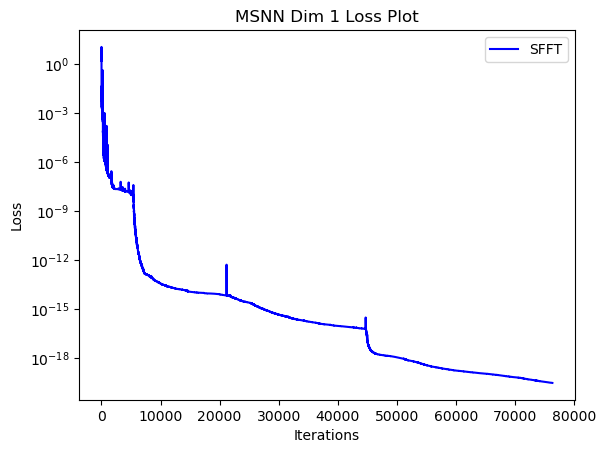

In [ ]:
loss_s = np.concatenate([stage.loss for stage in MSNN_SFFT.stages])
# loss_f = np.concatenate([stage.loss for stage in MSNN_FFT.stages])
plt.figure()
plt.plot(loss_s, 'b-', label='SFFT')
# plt.plot(loss_f, 'r', label='FFT')
plt.yscale("log")
plt.title(f"MSNN Dim {dim} Loss Plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [7]:
import pickle
def save_model(model, file_path):
    model_data = {
        'dim': model.dim,
        'N': model.N,
        'layers': model.layers,
        'lt': model.lt,
        'ut': model.ut,
        'stages': []
    }

    for stage in model.stages:
        stage_data = {
            'weights': [w.numpy() for w in stage.weights],
            'biases': [b.numpy() for b in stage.biases],
            'lt': stage.lt,
            'ut': stage.ut,
            'kappa': stage.kappa,
            'acts': stage.actv
        }
        model_data['stages'].append(stage_data)

    with open(file_path, 'wb') as f:
        pickle.dump(model_data, f)

def load_model(file_path, x_train):
    with open(file_path, 'rb') as f:
        model_data = pickle.load(f)
        
    model = MultistageNeuralNetwork(x_train, len(model_data['layers']) - 2, model_data['layers'][1])
    model.dim = model_data['dim']
    model.N = model_data['N']
    model.layers = model_data['layers']
    model.lt = model_data['lt']
    model.ut = model_data['ut']

    for stage_data in model_data['stages']:
        nn = NeuralNet(x_train, y_train, layers=model.layers, kappa=stage_data['kappa'],
            lt=stage_data['lt'], ut=stage_data['ut'], acts=0
        )
        nn.weights = [tf.Variable(w, dtype=tf.float64) for w in stage_data['weights']]
        nn.biases = [tf.Variable(b, dtype=tf.float64) for b in stage_data['biases']]
        model.stages.append(nn)

    return model

[]


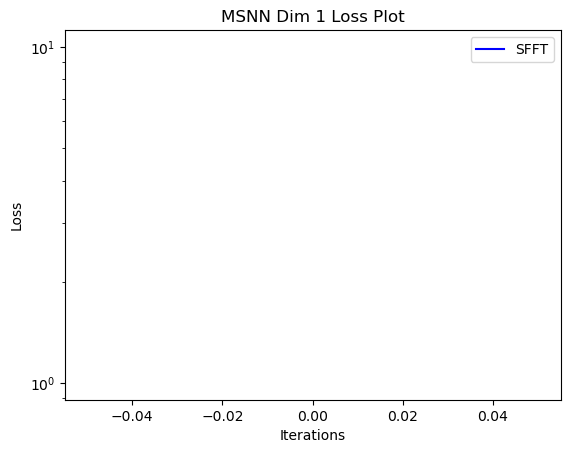

In [ ]:
# save_model(MSNN_SFFT, "./models/test_model.pkl")
model1 = load_model("./models/model_dim1.pkl", x_train)
loss_s = np.concatenate([stage.loss for stage in model1.stages])
# loss_f = np.concatenate([stage.loss for stage in MSNN_FFT.stages])
plt.figure()
plt.plot(loss_s, 'b-', label='SFFT')
# plt.plot(loss_f, 'r', label='FFT')
plt.yscale("log")
plt.title(f"MSNN Dim {dim} Loss Plot")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

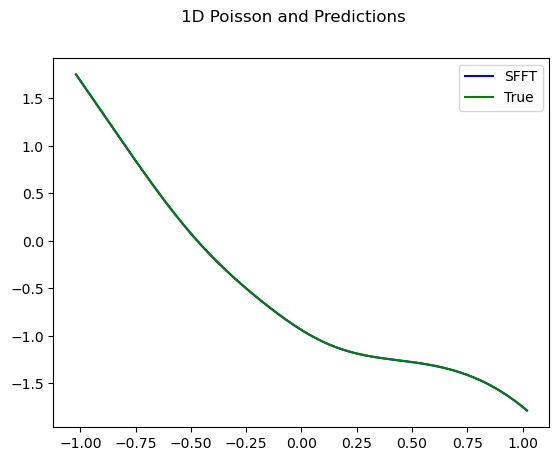

In [6]:
yhat_1_sfft = test_model.stages[0].predict(x_train)
# yhat_1_fft = MSNN_FFT.stages[0].predict(x_train)

plt.figure()
plt.suptitle("1D Poisson and Predictions")
plt.plot(x_train, yhat_1_sfft, 'b', label='SFFT')
# plt.plot(x_train, yhat_1_fft, 'r', label="FFT")
plt.plot(x_train, y_train, 'g', label='True')
plt.legend()
plt.show()

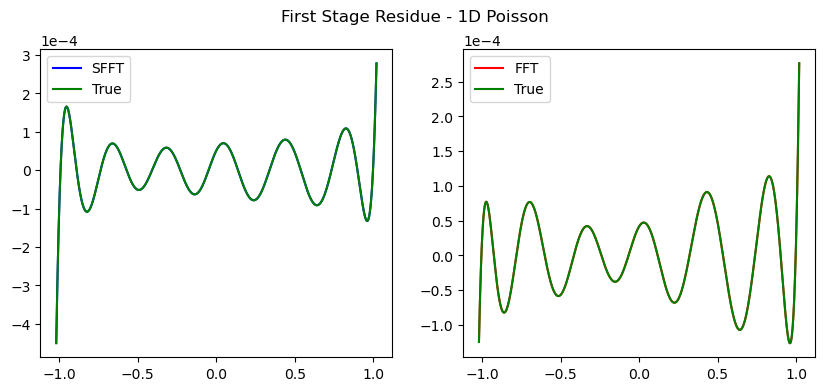

In [21]:
residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(1)])
yhat_2_sfft = MSNN_SFFT.stages[1].predict(x_train)

residue_fft = y_train - tf.add_n([MSNN_FFT.stages[j].predict(x_train) for j in range(1)])
yhat_2_fft = MSNN_FFT.stages[1].predict(x_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("First Stage Residue - 1D Poisson")
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.plot(x_train, yhat_2_sfft, 'b', label='SFFT')
ax1.plot(x_train, residue_sfft, 'g', label='True')
ax1.legend()

ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(x_train, yhat_2_fft, 'r', label='FFT')
ax2.plot(x_train, residue_fft, 'g', label='True')
ax2.legend()
plt.show()

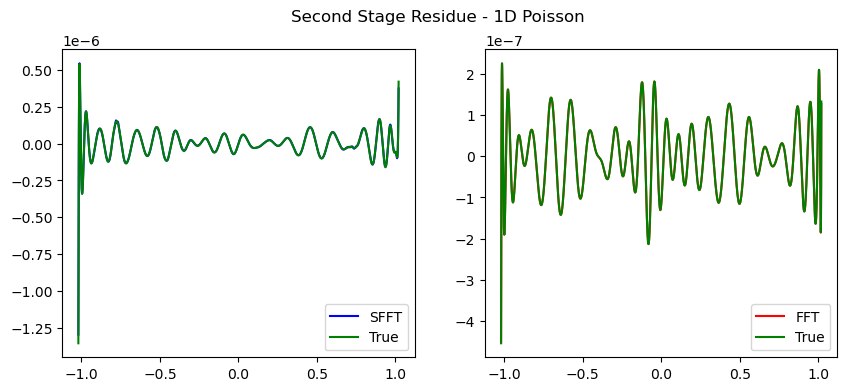

In [23]:
residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(2)])
yhat_3_sfft = MSNN_SFFT.stages[2].predict(x_train)

residue_fft = y_train - tf.add_n([MSNN_FFT.stages[j].predict(x_train) for j in range(2)])
yhat_3_fft = MSNN_FFT.stages[2].predict(x_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Second Stage Residue - 1D Poisson")
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.plot(x_train, yhat_3_sfft, 'b', label='SFFT')
ax1.plot(x_train, residue_sfft, 'g', label='True')
ax1.legend()

ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(x_train, yhat_3_fft, 'r', label='FFT')
ax2.plot(x_train, residue_fft, 'g', label='True')
ax2.legend()
plt.show()

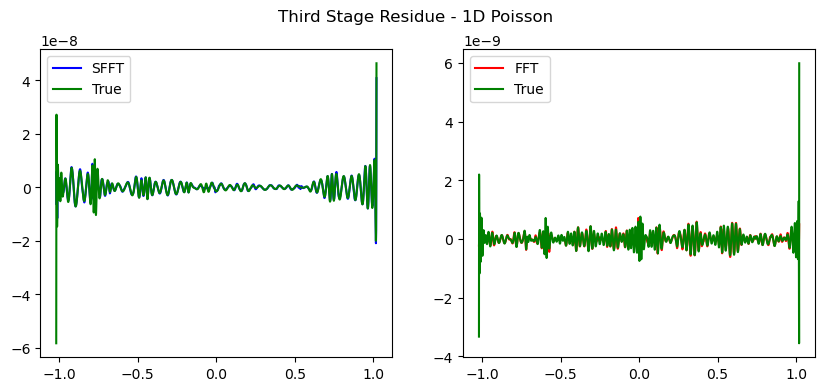

In [22]:
residue_sfft = y_train - tf.add_n([MSNN_SFFT.stages[j].predict(x_train) for j in range(3)])
yhat_4_sfft = MSNN_SFFT.stages[3].predict(x_train)

residue_fft = y_train - tf.add_n([MSNN_FFT.stages[j].predict(x_train) for j in range(3)])
yhat_4_fft = MSNN_FFT.stages[3].predict(x_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
plt.suptitle("Third Stage Residue - 1D Poisson")
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.plot(x_train, yhat_4_sfft, 'b', label='SFFT')
ax1.plot(x_train, residue_sfft, 'g', label='True')
ax1.legend()

ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.plot(x_train, yhat_4_fft, 'r', label='FFT')
ax2.plot(x_train, residue_fft, 'g', label='True')
ax2.legend()
plt.show()